In [1]:
from urllib.request import urlretrieve
import zipfile, os

In [2]:
data_file_path = "data_manager_split_datasets/Movielens10M/"
data_file_name = data_file_path + "movielens_10m.zip"

if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)
    
if not os.path.exists(data_file_name):
    urlretrieve("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)

In [3]:
data_file = zipfile.ZipFile(data_file_name)
URM_path = data_file.extract("ml-10M100K/ratings.dat", path=data_file_path + "decompressed/")
URM_file = open(URM_path, 'r')

In [4]:
type(URM_file)

_io.TextIOWrapper

In [5]:
import pandas as pd

In [6]:
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path,
                                sep='::',
                                header=None,
                                dtype={0:int, 1:int, 2:float, 3:int},
                                engine='python')
URM_all_dataframe.columns = ['UserID', 'ItemID', 'Interaction', 'Timestamp']

In [7]:
URM_all_dataframe.head()

,UserID,ItemID,Interaction,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [8]:
print("Number of items\t {}, Number of users\t {}".format(len(URM_all_dataframe['ItemID'].unique()), len(URM_all_dataframe['UserID'].unique())))
print("Number of interactions\t {}".format(URM_all_dataframe['Interaction'].count()))
print("Max value of UserID\t {}, Max value of ItemID\t {}".format(URM_all_dataframe['UserID'].max(), URM_all_dataframe['ItemID'].max()))

Number of items	 10677, Number of users	 69878
Number of interactions	 10000054
Max value of UserID	 71567, Max value of ItemID	 65133


In [9]:
mapped_id, original_id = pd.factorize(URM_all_dataframe['UserID'].unique())
user_original_ID_to_index = pd.Series(data=mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe['ItemID'].unique())
item_original_ID_to_index = pd.Series(data=mapped_id, index=original_id)

In [10]:
URM_all_dataframe['UserID'] = URM_all_dataframe['UserID'].map(user_original_ID_to_index)
URM_all_dataframe['ItemID'] = URM_all_dataframe['ItemID'].map(item_original_ID_to_index)

In [11]:
URM_all_dataframe.head(n=20)

,UserID,ItemID,Interaction,Timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
5,0,5,5.0,838983392
6,0,6,5.0,838984474
7,0,7,5.0,838983653
8,0,8,5.0,838984885
9,0,9,5.0,838983707


In [12]:
userID_unique = URM_all_dataframe['UserID'].unique()
itemID_unique = URM_all_dataframe['ItemID'].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print("Max value of UserID\t {}, Max value of ItemID\t {}".format(userID_unique.max(), itemID_unique.max()))
print("Number of interactions\t {}".format(n_interactions))

print("Average interactions per user {:.2f}\nAverage interactions per item {:.2f}".format(n_interactions/n_users, n_interactions/n_items))

print("Sparsity {:.2f} %".format((1 - n_interactions/(n_users*n_items))*100))

Number of items	 10677, Number of users	 69878
Max value of UserID	 69877, Max value of ItemID	 10676
Number of interactions	 10000054
Average interactions per user 143.11
Average interactions per item 936.60
Sparsity 98.66 %


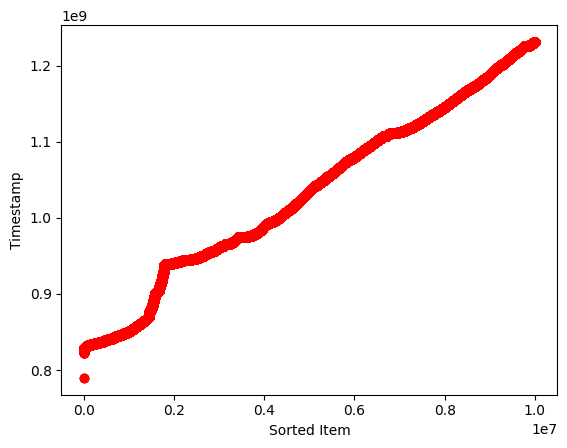

In [14]:
import matplotlib.pyplot as pyplot

timestamp_sorted = URM_all_dataframe['Timestamp'].values.copy()
timestamp_sorted.sort()

pyplot.plot(timestamp_sorted, 'ro')
pyplot.ylabel('Timestamp')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [15]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe['Interaction'].values, (URM_all_dataframe['UserID'].values, URM_all_dataframe['ItemID'].values)))
URM_all = URM_all.tocsr()

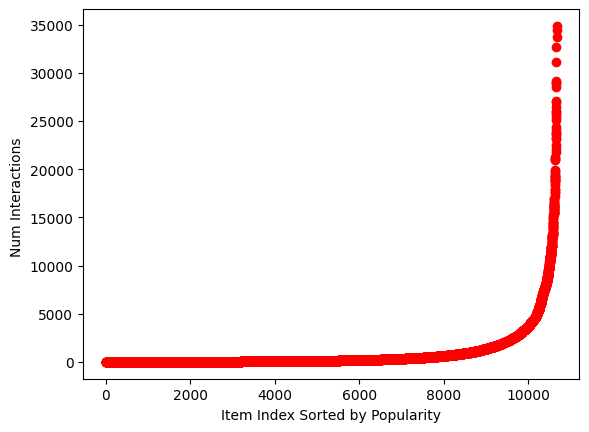

In [17]:
import numpy as np

item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity = np.sort(item_popularity)

pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Item Index Sorted by Popularity')
pyplot.show()

In [18]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}\n".format(item_popularity.mean()))
print("Average per-item interactions for the top 10% popular items {:.2f}\n".format(item_popularity[-ten_percent:].mean()))
print("Average per-item interactions for the least 10% popular items {:.2f}\n".format(item_popularity[:ten_percent].mean()))
print("Average per-item interactions for the median 10% popular items {:.2f}\n".format(item_popularity[int(n_items/2-ten_percent/2):int(n_items/2+ten_percent/2)].mean()))

Average per-item interactions over the whole dataset 936.60

Average per-item interactions for the top 10% popular items 6479.52

Average per-item interactions for the least 10% popular items 5.23

Average per-item interactions for the median 10% popular items 136.48


In [19]:
print("Number of items with zero interactions {} out of {}".format(np.sum(item_popularity==0), n_items))

Number of items with zero interactions 0 out of 10677


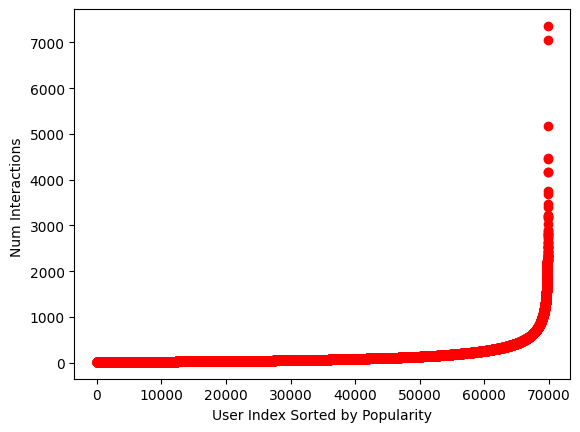

In [21]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)

pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('User Index Sorted by Popularity')
pyplot.show()

In [22]:
train_test_split = 0.8

n_interactions = URM_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

In [35]:
URM_all = URM_all.tocoo()
URM_train = sps.csr_matrix((URM_all.data[train_mask], (URM_all.row[train_mask], URM_all.col[train_mask])))

In [36]:
test_mask = np.logical_not(train_mask)
URM_test = sps.csr_matrix((URM_all.data[test_mask], (URM_all.row[test_mask], URM_all.col[test_mask])))

In [39]:
user_id = 124
relevant_items = URM_test[user_id].indices
reccomended_items = np.array([241, 1622, 15, 857, 5823])
is_relevant = np.in1d(reccomended_items, relevant_items, assume_unique=True)